In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import random
data_load = False

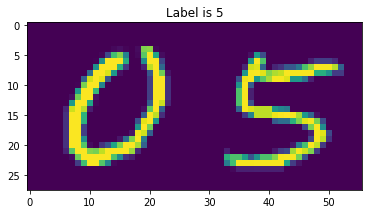

In [2]:
if not data_load :
    train_x = pd.read_csv('./classification-of-mnist-digits/train.csv')
    train_y = pd.read_csv('./classification-of-mnist-digits/train_result.csv')
    test_x = pd.read_csv('./classification-of-mnist-digits/test.csv')
    data_load = True
for i in train_x.index:
    data = train_x.loc[i].values[:-1].reshape(28,56)
    plt.title(f'Label is {train_y.loc[i].values[1]}')
    plt.imshow(data)
    plt.show()
    break

In [3]:
val_x = train_x[:10000]
val_y = train_y[:10000]
train_x = train_x[10000:]
train_y = train_y[10000:]

In [4]:
train_x = train_x.iloc[: , :-1]
val_x = val_x.iloc[: , :-1]
test_x = test_x.iloc[: , :-1]

In [5]:
train_y = train_y.iloc[:,1:]
val_y = val_y.iloc[:,1:]
print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape)

(40000, 1568) (40000, 1) (10000, 1568) (10000, 1) (10000, 1568)


In [6]:
train_x = train_x.to_numpy()
val_x = val_x.to_numpy()
test_x = test_x.to_numpy()
train_y = train_y.to_numpy()
val_y = val_y.to_numpy()

In [7]:
def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])
train_y = one_hot(train_y, 19)
val_y = one_hot(val_y, 19)

In [8]:
print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape)

(40000, 1568) (40000, 19) (10000, 1568) (10000, 19) (10000, 1568)


In [95]:
class NN(object):
  """
    Implements an 1-NN.
  """

  def __init__(self,
               dims=(1568, 19),
               epsilon=1e-6,            # Correction factor
               lr=0.1,                 # Learning rate
              ):
    """
      Constructor of the NN class.

      dims: list or tuple or np.array, default (784, 128, 64, 10)
        Valeurs de h_0 (nombre de caractéristiques), h_1 (dim. cachée 1), h_2 (dim. cachée 2), h_3 (nombre de classes de sortie).
      activation: string, default "relu"
        La fonction d'activation.
      epsilon: float or double, default 1e-6
        Facteur de correction des probabilités.
      lr: float or double, default 0.01
        Taux d'apprentissage.
      seed: int, default 0
        Random seed.
    """
    super(NN, self).__init__()

    self.dims = dims
    self.epsilon = epsilon
    self.lr = lr

  def initialize_weights(self):
    """
      Résultats : Initialise les weights du MLP à partir de uniform(-1/sqrt(h_0), 1/sqrt(h_0)) et les biais à zéro.
    """

    self.weights = {}
    # self.weights is a dictionary with keys W1, b1, W2, b2, ..., Wm, Bm where m - 1 is the number of hidden layers
    # The keys W1, W2, ..., Wm correspond to weights while b1, b2, ..., bm correspond to biases
    self.weights[f"W{1}"] = np.random.normal(0,1, size = (self.dims[0], self.dims[1]))
    self.weights[f"b{1}"] = np.random.normal(0,1, size = (1, self.dims[1]))

  def softmax(self, x):
    """
      x: np.array
        Entrées pour calculer le softmax. x peut contenir un batch d'entrées !

      Outputs: Implémente la fonction softmax, renvoie l'array contenant softmax(x).
    """
    res = np.array([])
    for i in range(x.shape[0]):
      res = np.append(res, np.exp(x[i] - np.max(x[i]))/np.sum(np.exp(x[i] - np.max(x[i]))))
    return res.reshape(x.shape)

  def forward(self, x):
    """
      x: np.array
        Entrées du MLP. Notez que x peut contenir plusieurs exemples d'entrée.

      Outputs: Implémente la passe forward, retourne le cache comme décrit ci-dessous.
    """
    cache = {"Z0": x}
    # le cache est un dictionnaire avec les clés Z0, A1, Z1, ..., Am, Zm où m - 1 est le nombre de couches cachées
    # Z0 contient juste les entrées x du réseau
    # Ai correspond à la préactivation de la couche i, Zi correspond à l'activation de la couche i
    cache[f"A{1}"] = np.dot(cache[f"Z{0}"], self.weights[f"W{1}"]) + self.weights[f"b{1}"]
    cache[f"Z{1}"] = self.softmax(cache[f"A{1}"])
    return cache

  def loss(self, prediction, labels):
    """
      prediction: np.array
        Probabilités prédites pour chaque classe pour les entrées. Peut contenir plusieurs exemples (un batch) !
      labels: np.array
        Vraies labels correspondant aux entrées (one-hot encoded). Peut contenir plusieurs exemples (un batch) !

      Outputs: Renvoie la perte de l'entropie croisée (moyenne sur le nombre d'entrées).
    """
    prediction[np.where(prediction < self.epsilon)] = self.epsilon
    prediction[np.where(prediction > 1 - self.epsilon)] = 1 - self.epsilon
    return -np.mean(np.sum(labels * np.log(prediction), axis=1))

  def backward(self, cache, labels):
    """
      cache: np.array
        Résultats de la passe backward. Cela peut être pour plusieurs exemples (un batch).
      labels: np.array
        Vraies labels correspondant aux entrées dans le cache. Peut contenir plusieurs exemples (un batch) !

      Outputs: Implémente le backward pass, retourne les grads comme décrit ci-dessous.
    """
    output = cache[f"Z{1}"]
    grads = {}
    grads[f"dA{1}"] = output - labels
    grads[f"dW{1}"] = np.dot(cache[f"Z{0}"].T, grads[f"dA{1}"]) / labels.shape[0]
    grads[f"db{1}"] = grads[f"dA{1}"].mean(axis=0, keepdims=True)
    return grads

  def update(self, grads):
    """
      grads: np.dictionary
        Gradients obtenus à partir de la passe backward.

      Results: Met à jour les poids et les biais du réseau.
    """
    self.weights[f"W{1}"] -= self.lr * grads[f"dW{1}"]
    self.weights[f"b{1}"] -= self.lr * grads[f"db{1}"]

  def accuracy_score(self, y_pred, y_true):
    """
      y_pred: np.array
        Prédictions du réseau. Peut contenir plusieurs exemples (un batch) !
      y_true: np.array
        Vraies labels correspondant aux entrées dans y_pred. Peut contenir plusieurs exemples (un batch) !

      Outputs: Renvoie le score d'accuracy.
    """
    return np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))

In [98]:
def train_loop(epoch, model, train_x, train_y):
  """
    epoch: int
      Numéro de l'époque d'apprentissage actuelle (à partir de 0).
    model: ResNet18
      Le modèle à entraîner, qui est une instance de la classe ResNet18.
    train_loader: DataLoader
      Training dataloader.
    criterion: Module
      Un objet Module qui évalue la perte de l'entropie croisée.
    optimizer: Optimizer
      Un objet Optimizer pour l'optimiseur Adam.

    Outputs: Retourne la moyenne de train_acc et train_loss pour l'époque actuelle.
  """
  train_acc = 0.
  train_loss = 0.
  for i, X in enumerate(train_x):
    X = np.array([X])
    cache = model.forward(X)
    loss = model.loss(cache[f"Z{1}"], train_y[i])
    grads = model.backward(cache, train_y[i])
    model.update(grads)
    train_acc += np.argmax(cache[f"Z{1}"]) == np.argmax(train_y[i])
    train_loss += loss
  train_acc, train_loss = train_acc / len(train_x), train_loss / len(train_x)
  return train_acc, train_loss


def valid_loop(epoch, model, valid_x, valid_y):
  """
    epoch: int
      Numéro de l'époque d'apprentissage actuelle (à partir de 0).
    model: ResNet18
      Le modèle à entraîner, qui est une instance de la classe ResNet18.
    valid_loader: DataLoader
      Validation dataloader.
    criterion: Module
      Un objet Module qui évalue la perte de l'entropie croisée.

    Outputs: Retourne la moyenne de valid_acc et valid_loss pour l'époque actuelle.
  """
  valid_acc = 0.
  valid_loss = 0.
  for i, X in enumerate(valid_x):
    X = np.array([X])
    cache = model.forward(X)
    loss = model.loss(cache[f"Z{1}"], valid_y[i])
    valid_acc += np.argmax(cache[f"Z{1}"]) == np.argmax(valid_y[i])
    valid_loss += loss
  valid_acc, valid_loss = valid_acc / len(valid_x), valid_loss / len(valid_x)
  return valid_acc, valid_loss

In [101]:
train_accs, train_losses, val_accs, val_losses = [], [], [], []
n_epochs = 100

model = NN()
model.initialize_weights()

pbar = tqdm(range(n_epochs), desc = "Processing first epoch  ")

for epoch in pbar:
    # Training
    train_acc, train_loss = train_loop(epoch, model, train_x, train_y)
    pbar.set_description(f"Epoch: {epoch}, Train Loss: {train_loss}, Train Accuracy: {train_acc}  ")
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Validation
    val_acc, val_loss = valid_loop(epoch, model, val_x, val_y)
    pbar.set_description(f"Epoch: {epoch}, Valid Loss: {val_loss}, Valid Accuracy: {val_acc}  ")
    val_accs.append(val_acc)
    val_losses.append(val_loss)

Epoch: 99, Valid Loss: 2.5503549482495003, Valid Accuracy: 0.1995  : 100%|██████████| 100/100 [30:10<00:00, 18.11s/it] 


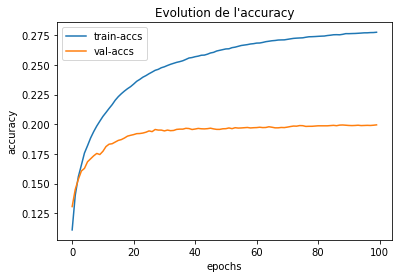

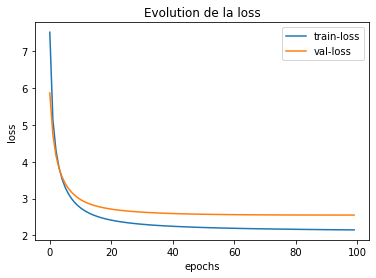

In [102]:
plt.plot(train_accs)
plt.plot(val_accs)
plt.xlabel("epochs")
plt.ylabel('accuracy')
plt.legend(["train-accs", "val-accs"])
plt.title("Evolution de l'accuracy")
plt.show()

plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel("epochs")
plt.ylabel('loss')
plt.legend(["train-loss", "val-loss"])
plt.title("Evolution de la loss")
plt.show()

In [103]:
def predict(model, x):
    """
        model: NN
        Instance de la classe NN.
        x: np.array
        Données d'entrée.
    
        Results: Renvoie les labels prédits par le modèle.
    """
    return np.argmax(model.forward(x)[f"Z{1}"], axis=1)

In [104]:
preds = predict(model, test_x)

In [105]:
print(preds, preds.shape)

[7 7 8 ... 9 5 6] (10000,)


In [106]:
# creating a list of index names
index_values = [i for i in range(0, 10000)]
# creating a list of column names
column_values = ['Index', 'Class']
  
# creating the dataframe
df = pd.DataFrame(columns = column_values, index = index_values)
df['Class']= preds
df['Index']= index_values
print(df)

      Index  Class
0         0      7
1         1      7
2         2      8
3         3      7
4         4      3
...     ...    ...
9995   9995      8
9996   9996     12
9997   9997      9
9998   9998      5
9999   9999      6

[10000 rows x 2 columns]


In [107]:
df.to_csv('./submission.csv', index=False)